In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import re

In [2]:
print("Step 1: Loading and preparing data...")

# List of your original Excel file names
files = [
    'Yearly Demand Profile 2017.xlsx',
    'Yearly Demand Profile 2018.xlsx',
    'Yearly Demand Profile 2019.xlsx',
    'Yearly Demand Profile 2020.xlsx',
    'Yearly Demand Profile 2021.xlsx',
    'Yearly Demand Profile 2022.xlsx',
    'Yearly Demand Profile 2023.xlsx'
]

try:
    df_list = []
    # Loop through each file to add the year from the filename
    for f in files:
        year = re.search(r'\d{4}', f).group()
        temp_df = pd.read_excel(f)
        temp_df['full_date'] = temp_df['Date'] + ' ' + year
        df_list.append(temp_df)

    df = pd.concat(df_list)

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("\nPlease make sure all the Excel files are in the same directory as your script.")
    exit()

# --- Data Cleaning and Preprocessing ---
df = df[df['State'].str.contains('Maharashtra', na=False)].copy()

# Convert 'full_date' with a specific format to remove the warning
df['datetime'] = pd.to_datetime(df['full_date'], format='%d-%b %I%p %Y')
df.set_index('datetime', inplace=True)

df.rename(columns={'Hourly Demand Met (in MW)': 'demand_mw'}, inplace=True)
df.drop(['Date', 'State', 'full_date'], axis=1, inplace=True)
df.sort_index(inplace=True)
df.ffill(inplace=True)

print("Data loading complete.")

Step 1: Loading and preparing data...
Data loading complete.


In [3]:
print("\nStep 2: Performing feature engineering...")

def create_original_features(df):
    """Create time series features from the datetime index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['lag_1hr'] = df['demand_mw'].shift(1)
    df['lag_24hr'] = df['demand_mw'].shift(24)
    df['lag_168hr'] = df['demand_mw'].shift(168)
    return df

df_features = create_original_features(df)
df_features.dropna(inplace=True)

print("Feature engineering complete.")


Step 2: Performing feature engineering...
Feature engineering complete.


In [4]:
print("\nStep 3: Training and optimizing the hybrid model...")

# --- Chronological Data Split (last 7 days = test set) ---
# Access the index directly and assign it to a new 'datetime' column
df_features['datetime'] = df_features.index
last_date = df_features['datetime'].max()
test_start = last_date - pd.Timedelta(days=7)

train_val_df = df_features[df_features['datetime'] < test_start]
test_df      = df_features[df_features['datetime'] >= test_start]

# Train/val = 85/15 split (chronological)
train_size = int(len(train_val_df) * 0.85)
train_df   = train_val_df.iloc[:train_size]
val_df     = train_val_df.iloc[train_size:]

print(f"Train rows: {len(train_df)}, Val rows: {len(val_df)}, Test rows: {len(test_df)}")
print(f"Test set covers: {test_df['datetime'].min()} → {test_df['datetime'].max()}")

# --- Features and Target ---
FEATURES = ['hour', 'dayofweek', 'month', 'year', 'lag_1hr', 'lag_24hr', 'lag_168hr']
TARGET = 'demand_mw'

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val, y_val     = val_df[FEATURES], val_df[TARGET]
X_test, y_test   = test_df[FEATURES], test_df[TARGET]

# --- XGBoost Component ---
print("Training XGBoost model...")
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, n_jobs=-1)

# Safe early stopping (XGBoost >=2.0 has no early_stopping_rounds)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_pred_val = xgb.predict(X_val)
xgb_pred_test = xgb.predict(X_test)
print("XGBoost training complete.")

# --- Scaling and Sequencing for RNNs ---
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df[[TARGET] + FEATURES])
scaled_val   = scaler.transform(val_df[[TARGET] + FEATURES])
scaled_test  = scaler.transform(test_df[[TARGET] + FEATURES])

SEQ_LENGTH = 48

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])
    return np.array(X), np.array(y)

X_train_seq, y_train_seq = create_sequences(scaled_train, SEQ_LENGTH)
X_val_seq, y_val_seq     = create_sequences(scaled_val, SEQ_LENGTH)
X_test_seq, y_test_seq   = create_sequences(scaled_test, SEQ_LENGTH)

# --- Target Scaler (moved from nMhybbToPZ-W) ---
target_scaler = MinMaxScaler().fit(train_df[[TARGET]])


Step 3: Training and optimizing the hybrid model...
Train rows: 51855, Val rows: 9152, Test rows: 169
Test set covers: 2023-12-24 23:00:00 → 2023-12-31 23:00:00
Training XGBoost model...
XGBoost training complete.


In [5]:
print("Training GRU model...")
gru = Sequential([
    Input(shape=(SEQ_LENGTH, X_train_seq.shape[2])),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(1)
])
gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stop = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)

gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

gru_pred_val  = target_scaler.inverse_transform(gru.predict(X_val_seq))
gru_pred_test = target_scaler.inverse_transform(gru.predict(X_test_seq))
print("GRU training complete.")

# --- Optimize Hybrid Weights ---
print("Optimizing hybrid weights...")
y_val_aligned = y_val.values[SEQ_LENGTH:]
xgb_val_aligned = xgb_pred_val[SEQ_LENGTH:]

best_mse = float('inf')
best_weight = 0
for w in np.arange(0, 1.01, 0.01):
    hybrid_val_pred = (w * xgb_val_aligned) + ((1 - w) * gru_pred_val.flatten())
    mse = mean_squared_error(y_val_aligned, hybrid_val_pred)
    if mse < best_mse:
        best_mse = mse
        best_weight = w

print(f"Optimal XGBoost Weight found: {best_weight:.2f}")

# --- Final Hybrid Prediction on Test Set ---
if len(test_df) > SEQ_LENGTH:
    y_test_aligned = y_test.values[SEQ_LENGTH:]
    xgb_test_aligned = xgb_pred_test[SEQ_LENGTH:]
    hybrid_test_pred = (best_weight * xgb_test_aligned) + ((1 - best_weight) * gru_pred_test.flatten())
    print("Hybrid model test prediction complete.")
else:
    print("⚠️ Test data too short for GRU sequence length, skipping hybrid test prediction.")

Training GRU model...
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
GRU training complete.
Optimizing hybrid weights...
Optimal XGBoost Weight found: 0.14
Hybrid model test prediction complete.



Step 4: Evaluating final models on the test set...
Training LSTM model...
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM training complete.
Training Stacked LSTM model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Stacked LSTM training complete.
Training CNN-BiLSTM model...
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000255091856C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and h

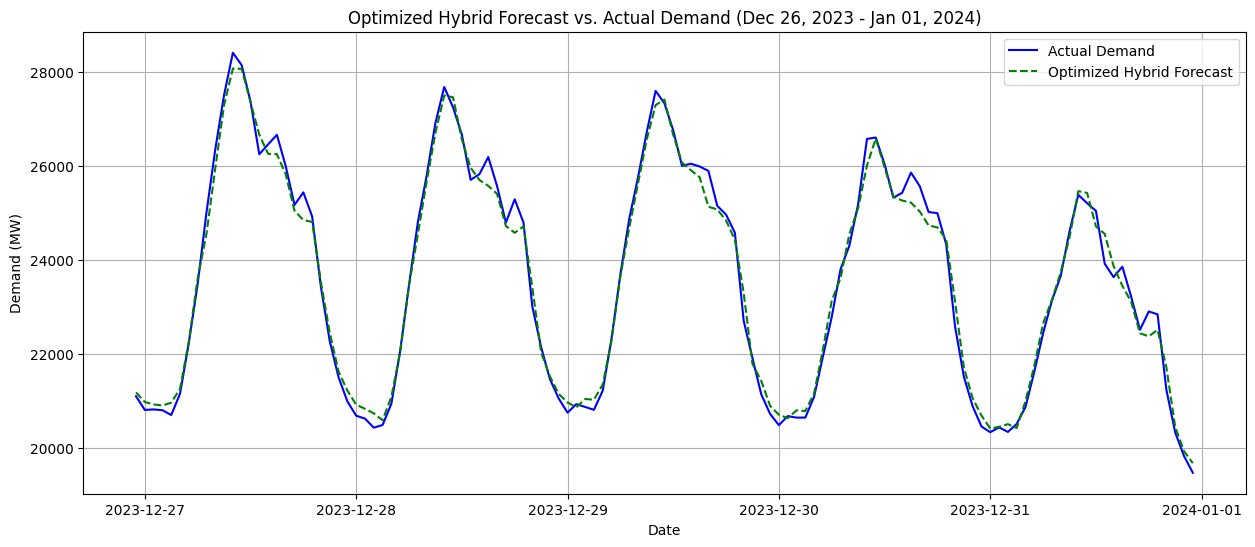


Analysis complete.


In [6]:
import tensorflow as tf

print("\nStep 4: Evaluating final models on the test set...")

# --- Create final predictions ---
# Add checks before accessing elements of y_test, xgb_pred_test, and gru_pred_test
if not y_test.empty and len(y_test) > SEQ_LENGTH and len(xgb_pred_test) > 0 and len(gru_pred_test) > 0:
    y_test_aligned = y_test.values[SEQ_LENGTH:]
    xgb_pred_test_aligned = xgb_pred_test[SEQ_LENGTH:]
    hybrid_pred_test = (best_weight * xgb_test_aligned) + ((1 - best_weight) * gru_pred_test.flatten())

    # --- Train other models (moved from subsequent cells) ---
    print("Training LSTM model...")
    lstm = Sequential([
        Input(shape=(SEQ_LENGTH, X_train_seq.shape[2])),
        tf.keras.layers.LSTM(64),
        Dense(1)
    ])
    lstm.compile(optimizer=Adam(0.001), loss='mse')
    lstm.fit(X_train_seq, y_train_seq,
             validation_data=(X_val_seq, y_val_seq),
             epochs=50, batch_size=64,
             callbacks=[early_stop], verbose=0)

    lstm_pred_val = target_scaler.inverse_transform(lstm.predict(X_val_seq))
    lstm_pred_test = target_scaler.inverse_transform(lstm.predict(X_test_seq))
    print("LSTM training complete.")

    print("Training Stacked LSTM model...")
    stacked_lstm = Sequential([
        Input(shape=(SEQ_LENGTH, X_train_seq.shape[2])),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64),
        Dense(1)
    ])
    stacked_lstm.compile(optimizer=Adam(0.001), loss='mse')
    stacked_lstm.fit(X_train_seq, y_train_seq,
                     validation_data=(X_val_seq, y_val_seq),
                     epochs=50, batch_size=64,
                     callbacks=[early_stop], verbose=0)

    stacked_lstm_pred_test = target_scaler.inverse_transform(stacked_lstm.predict(X_test_seq))
    print("Stacked LSTM training complete.")

    print("Training CNN-BiLSTM model...")
    cnn_bilstm = Sequential([
        Input(shape=(SEQ_LENGTH, X_train_seq.shape[2])),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(1)
    ])
    cnn_bilstm.compile(optimizer=Adam(0.001), loss='mse')
    cnn_bilstm.fit(X_train_seq, y_train_seq,
                   validation_data=(X_val_seq, y_val_seq),
                   epochs=50, batch_size=64,
                   callbacks=[early_stop], verbose=0)

    cnn_bilstm_pred_test = target_scaler.inverse_transform(cnn_bilstm.predict(X_test_seq))
    print("CNN-BiLSTM training complete.")

    print("Training LSTM+XGBoost hybrid...")
    feature_extractor = Sequential([
        Input(shape=(SEQ_LENGTH, X_train_seq.shape[2])),
        tf.keras.layers.LSTM(64, return_sequences=False)
    ])
    lstm_features_train = feature_extractor.predict(X_train_seq)
    lstm_features_test = feature_extractor.predict(X_test_seq)

    lstm_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, n_jobs=-1)
    lstm_xgb.fit(lstm_features_train, y_train_seq)
    lstm_xgb_pred_test = lstm_xgb.predict(lstm_features_test)
    print("LSTM+XGBoost training complete.")


    # --- Print Metrics ---
    def print_metrics(model_name, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"\n--- {model_name} Metrics ---")
        print(f"R² Score : {r2:.4f}")
        print(f"MAE      : {mae:.2f} MW")
        print(f"RMSE     : {rmse:.2f} MW")

    print_metrics("XGBoost", y_test_aligned, xgb_pred_test_aligned)
    print_metrics("GRU", y_test_aligned, gru_pred_test.flatten())
    print_metrics("Optimized Hybrid", y_test_aligned, hybrid_pred_test)
    print_metrics("LSTM", y_test_aligned, lstm_pred_test.flatten())
    print_metrics("Stacked LSTM", y_test_aligned, stacked_lstm_pred_test.flatten())
    print_metrics("CNN-BiLSTM", y_test_aligned, cnn_bilstm_pred_test.flatten())
    print_metrics("LSTM+XGBoost", y_test_aligned, lstm_xgb_pred_test.flatten())


    # --- Final Plot ---
    print("\nGenerating final forecast plot...")

    # Combine all model predictions - moved from cell 1zFqC0Nncz8S
    extended_comparison_df = pd.DataFrame({
        'Actual Demand': y_test_aligned,
        'XGBoost Forecast': xgb_pred_test_aligned,
        'GRU Forecast': gru_pred_test.flatten(),
        'Optimized Hybrid Forecast': hybrid_pred_test,
        'LSTM Forecast': lstm_pred_test.flatten(),
        'Stacked LSTM Forecast': stacked_lstm_pred_test.flatten(),
        'CNN-BiLSTM Forecast': cnn_bilstm_pred_test.flatten(),
        'LSTM+XGBoost Forecast': lstm_xgb_pred_test.flatten()
    }, index=test_df.index[SEQ_LENGTH:])

    # Select a sample week for visualization - moved from cell 1zFqC0Nncz8S
    start_date_ext = extended_comparison_df.index.min()
    end_date_ext = start_date_ext + pd.Timedelta(days=6)
    sample_week_final = extended_comparison_df.loc[start_date_ext:end_date_ext]

    plt.figure(figsize=(15, 6))
    plt.plot(sample_week_final.index, sample_week_final['Actual Demand'], label='Actual Demand', color='blue')
    plt.plot(sample_week_final.index, sample_week_final['Optimized Hybrid Forecast'], label='Optimized Hybrid Forecast', color='green', linestyle='--')
    plt.title(f'Optimized Hybrid Forecast vs. Actual Demand ({start_date_ext.strftime("%b %d, %Y")} - {end_date_ext.strftime("%b %d, %Y")})')
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nAnalysis complete.")
else:
    print("Test data or predictions are insufficient for evaluating final models and generating plots.")


Generating final model comparison plot...


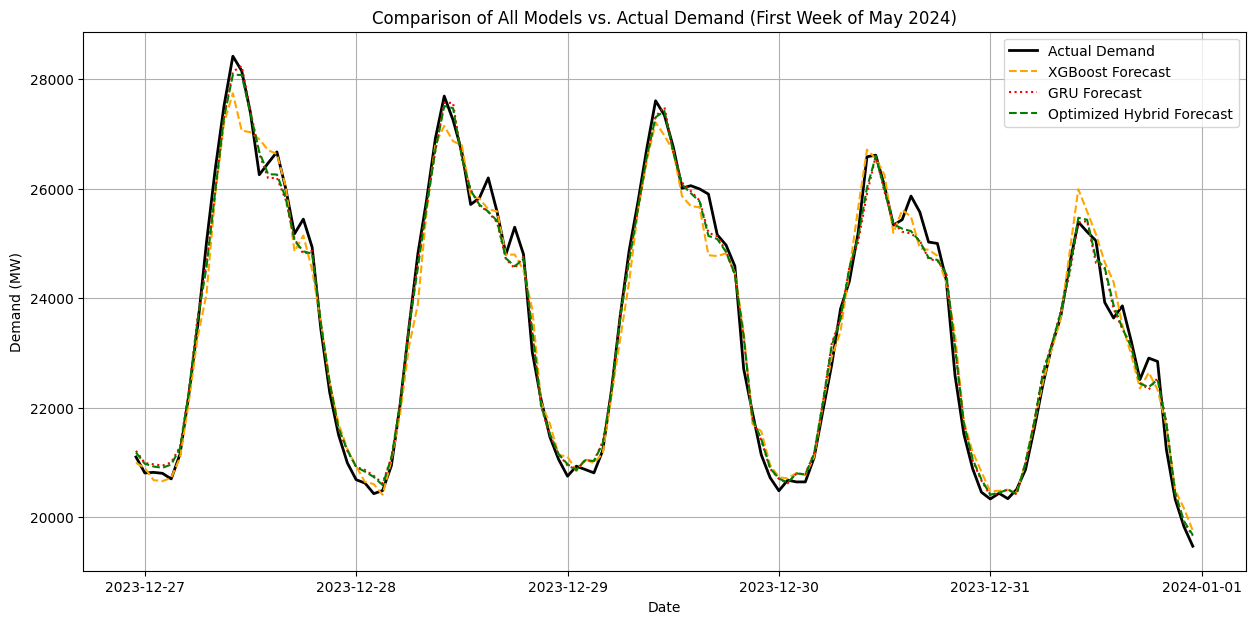

In [7]:
print("\nGenerating final model comparison plot...")

# Create a DataFrame with actuals and all model predictions
comparison_df = pd.DataFrame({
    'Actual Demand': y_test_aligned,
    'XGBoost Forecast': xgb_pred_test_aligned,
    'GRU Forecast': gru_pred_test.flatten(),
    'Optimized Hybrid Forecast': hybrid_pred_test
}, index=test_df.index[SEQ_LENGTH:])

# Select a sample week to visualize
sample_week_comparison = comparison_df.loc['2023-12-25':'2023-12-31']

# Create the plot
plt.figure(figsize=(15, 7))

# Plot the actual demand
plt.plot(sample_week_comparison.index, sample_week_comparison['Actual Demand'], label='Actual Demand', color='black', linewidth=2)

# Plot the model forecasts
plt.plot(sample_week_comparison.index, sample_week_comparison['XGBoost Forecast'], label='XGBoost Forecast', color='orange', linestyle='--')
plt.plot(sample_week_comparison.index, sample_week_comparison['GRU Forecast'], label='GRU Forecast', color='red', linestyle=':')
plt.plot(sample_week_comparison.index, sample_week_comparison['Optimized Hybrid Forecast'], label='Optimized Hybrid Forecast', color='green', linestyle='--')


# Add titles and labels
plt.title('Comparison of All Models vs. Actual Demand (First Week of May 2024)')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# This cell is now empty as the code has been moved to cell 3SAyYApLbabU

In [9]:
# This cell is now empty as the code has been moved to cell 3SAyYApLbabU

In [10]:
# This cell is now empty as the code has been moved to cell 3SAyYApLbabU

In [11]:
# This cell is now empty as the code has been moved to cell 3SAyYApLbabU

In [12]:
# This cell is now empty as the code has been moved to cell 3SAyYApLbabU

In [13]:
# This cell is now empty as the code has been moved to cell 3SAyYApLbabU